In [ ]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
#model and 
import math
from utils import *
from tqdm import tqdm
from models import MSE,MDcR,DSE,MVBG,CPCA,DPCA,MVP,LPP,LE
import scipy
datasets_names = ['BBC','MSRC-v1','NGs','Reuters','YALE']
datasets_names = ['Reuters']

for dt_name in datasets_names:
    # data
    X,labels=read_data(f'datasets/data sets/{dt_name}.mat')
    X = [X[0,i].T for  i  in range(X.shape[1])]
    X =  [x[:300,] for x in X] #d<=300 ,n = X[0].shape[1]
    if isinstance(X[0],scipy.sparse._csr.csr_matrix):
        X =   [np.asarray(x.todense()) for x in X]
    labels  = labels.squeeze()
    k = len(set(labels))
    #models
    model_list =  [MSE(), MDcR(),DSE(),MVBG(0.1,2,0.1), CPCA(),DPCA(), MVP(),LPP(),LE()]
    #main 
    res_nmi = [];res_acc =[];res_ari=[];res_purity  = []
    train_ratio=0.1
    d_max  =  min(math.floor((1-train_ratio)*X[0].shape[1]),int(np.min([x.shape[0] for x in X])) ) #min(d,測試x的維數)
    d_range  = range(k,d_max)
    model  =  CPCA()

    for d_ in tqdm(d_range): 
        nmi_list = [];acc_list =[]; ari_list=[]; purity_list=[]
        for i in range(1):
            # train_test split
            train_idx,test_idx = random_index(X[0].shape[1],train_ratio)
            X_train = [x[:,train_idx] for x in X]
            X_test = [x[:,test_idx] for x in X]
            y_test = labels[test_idx]
            #train

            # pred =  model.predict(X_test,0.5,2,1e6,d_,k,10) #MVP ok
            # pred   = model.predict(X_train,X_test,1e7,d_,k,200) #lPP ok 
            # pred  = model.predict(X_test,d_,20,k) #LE ok
            # pred = model.predict(X_train,X_test,d_,k) #DPCA ok
            # pred =  model.predict(X_test,0.5,d_,1e8,k,100) #MSE ok
            # pred   =  model.predict(X_test,d_,1e8,5,100,100)#mdcr ok
            # pred = model.predict(X_test,d_max,d_,k,1e8,30)# m: >=dmax ok mvbg
            # pred = model.dse(X_test,k,2,100) #dse 
            pred  = model.predict(X_train, X_test,d_,k)
            # criterion
            #nmi
            from sklearn.metrics.cluster import normalized_mutual_info_score,adjusted_rand_score
            from sklearn.metrics import homogeneity_score

            nmi = normalized_mutual_info_score(y_test,pred)
            nmi_list.append(nmi)
            #acc
            acc =   acc_score(y_test,pred)
            acc_list.append(acc)
            #ari
            ari =   adjusted_rand_score(y_test,pred)
            ari_list.append(ari)
            #purity
            purity  =  purity_score(y_test,pred)
            purity_list.append(purity)
        #
        nmi = np.mean(nmi_list)
        acc  = np.mean(acc_list)
        ari = np.mean(ari_list)
        purity = np.mean(purity_list)
        # 
        res_nmi.append(nmi)
        res_acc.append(acc)
        res_ari.append(ari)
        res_purity.append(purity)
    np.save(f'./result/nmi/{dt_name}/{model.name}.npy',res_nmi)
    np.save(f'./result/acc/{dt_name}/{model.name}.npy',res_acc)
    np.save(f'./result/ari/{dt_name}/{model.name}.npy',res_ari)
    np.save(f'./result/purity/{dt_name}/{model.name}.npy',res_purity)

    #plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(3,2))
    plt.plot(d_range,res_nmi)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


100%|██████████| 5/5 [01:30<00:00, 18.11s/it]


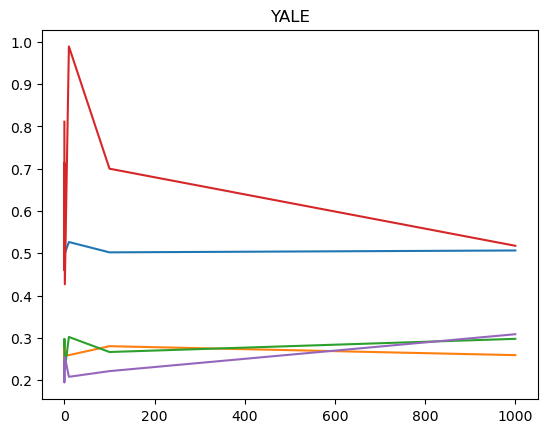

In [14]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
#model and 
import math
from utils import *
from tqdm import tqdm
from models import MVBG
import matplotlib.pyplot as plt
import scipy
datasets_names = ['BBC','MSRC-v1','NGs','Reuters','YALE']
# datasets_names=['YALE']
alpha = [0.001,0.01,0.1,1,10,100,1000]
beta = [0.001,0.01,0.1,1,10,100,1000]
gamma = [1.2, 1.5, 1.8, 2, 4, 6, 8, 10] 

d_ = 20

for dt_name in tqdm(datasets_names):
    # data
    X,labels=read_data(f'datasets/data sets/{dt_name}.mat')
    X = [X[0,i].T for  i  in range(X.shape[1])]
    X =  [x[:300,:500] for x in X] #d<=300 ,n = X[0].shape[1]
    if isinstance(X[0],scipy.sparse._csr.csr_matrix):
        X =   [np.asarray(x.todense()) for x in X]
    labels  = labels.squeeze()
    k = len(set(labels))
    train_ratio=0.1
    acc = []
    for a in alpha:
    # for b in beta:
        # train_test split
        train_idx,test_idx = random_index(X[0].shape[1],train_ratio)
        X_train = [x[:,train_idx] for x in X]
        X_test = [x[:,test_idx] for x in X]
        y_test = labels[test_idx]
        #train
        model=MVBG(a,gamma[0],beta[0])
        # model=MVBG(alpha[0],gamma[0],b)

        pred = model.predict(X_test,40,d_,k,1e6,30)# m: >=dmax ok mvbg
        #accuracy
        acc.append(acc_score(y_test,pred))
        # print(a)
    plt.plot(alpha,acc)
    plt.title(dt_name)

In [ ]:
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score,homogeneity_score
from sklearn.metrics import f1_score

from utils import *
a = np.array([1,1,2,2,3,3])
b = np.array([3,3,1,2,3,1])
# b  = np.array([1,1,3,2,1,3])

adjusted_rand_score(a,b)
# purity_score(b,b)
purity_score(a,b)


In [ ]:
from utils import *
X,labels=read_data(f'datasets/data sets/Reuters.mat')
X = [X[0,i].T for  i  in range(X.shape[1])]
np.asarray(X[2].todense()).shape

In [ ]:
# np.save('./result/NGs/mvbg_nmi.npy',res_nim)
res_nmi = np.load('./result/nmi/YALE/nmi_DPCA.npy')
res_nmi
